In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

# from desc import set_device
# set_device("gpu")

In [2]:
import numpy as np

np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
import warnings
import plotly.graph_objects as go
from diffrax import Tsit5, SaveAt, PIDController, Event, RecursiveCheckpointAdjoint

import desc
from desc.particles import (
    trace_particles,
    _trace_particles,
    VacuumGuidingCenterTrajectory,
    ManualParticleInitializerFlux,
    ManualParticleInitializerLab,
    SurfaceParticleInitializer,
    CurveParticleInitializer,
)
from desc.backend import vmap, print_backend_info, jnp
from desc.examples import get
from desc.grid import LinearGrid, Grid

from desc.plotting import (
    plot_3d,
    plot_field_lines,
    plot_particle_trajectories,
)

print_backend_info()

DESC version=0.16.0+9.g09d8b4394.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: CPU, with 17.76 GB available memory.


# Particle Tracing in DESC

Here we will try to show different functionality to trace particles, plot results and to see the differentiable version of the particle tracer in DESC. This notebook might not cover the whole functionality, but further questions are welcomed through Slack or Github.

## Some quick results

Before using the underlying function, let's use some of the plotting functions to see what trajectories look like.

`NCSX` equilibrium as example with 1 particle to trace. We will use vacuum guiding center trajectory model in flux coordinates for 3e-4 seconds.

In [3]:
eq = get("NCSX")
model = VacuumGuidingCenterTrajectory(frame="flux")
particles = ManualParticleInitializerFlux(
    rho0=0.4,
    theta0=0,
    zeta0=0,
    xi0=0.3,
    E=1e4, 
    m=4,
    q=2,
)
ts = np.linspace(0, 3e-4, 1000)

With only these inputs, we are ready to trace particles in DESC! Let's plot both the trajectory and the LCFS of the equilibrium.

In [4]:
# 3D plots use grid NFP=1 to plot all toroidal surfaces
# we are supprressing warnings here
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = plot_3d(eq, "|B|", alpha=0.3)
fig, data = plot_particle_trajectories(
    eq,
    model,
    particles,
    ts=ts,
    fig=fig,
    return_data=True,
)
fig

We can also use the output data to plot custom figures like particle $\rho$ vs time, top view trajectory etc.

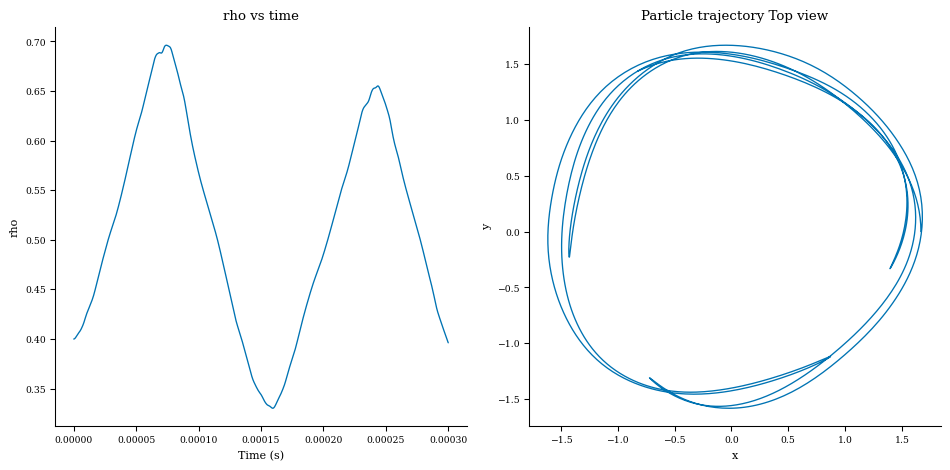

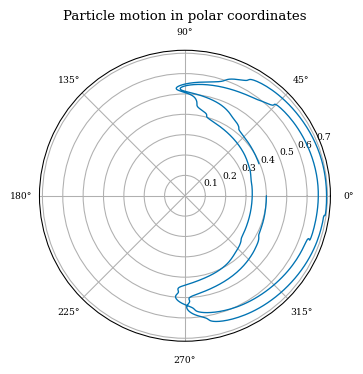

In [5]:
rho = data["rho"][0]
theta = data["theta"][0]
phi = data["phi"][0]
X = data["X"][0]
Y = data["Y"][0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(ts, rho)
ax[0].set_title("rho vs time")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("rho")
ax[1].plot(X, Y)
ax[1].set_title("Particle trajectory Top view")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")

plt.figure()
plt.polar(theta, rho)
plt.title("Particle motion in polar coordinates");

## Particle Tracing using a `MagneticField` Class

Everything is basically the same, but we just need to use lab coordinates $(R, \phi, Z)$. We will use an example coil field used for DESC testing. Note that the field might night have perfect $\mathbf{B}\cdot\hat{n}$.

In [6]:
eq = get("precise_QA")
field = desc.io.load("../../../tests/inputs/precise_QA_helical_coils.h5")

R0 = 1.2
phi0 = 0
Z0 = 0
model = VacuumGuidingCenterTrajectory(frame="lab")
particles = ManualParticleInitializerLab(
    R0=R0, phi0=phi0, Z0=Z0, xi0=0.3, E=1e4, m=4, q=2
)
ts = np.linspace(0, 3e-5, 1000)

For fun, let's also plot the field line corresponding to the initial position! Black line for particle trajectory and red one is for field line.

In [7]:
# 3D plots use grid NFP=1 to plot all toroidal surfaces
# we are supprressing warnings here
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = plot_3d(eq, "|B|", alpha=0.3)
fig = plot_particle_trajectories(
    field,
    model,
    particles,
    ts=ts,
    fig=fig,
)
plot_field_lines(
    field,
    R0=R0,
    Z0=Z0,
    phi0=phi0,
    ntransit=1.15,
    nphi_per_transit=300,
    color="red",
    lw=10,
    fig=fig,
)

## Particle Initializers

- Current possible options are:
    - `ManualParticleInitializerLab()` 
    - `ManualParticleInitializerFlux()` 
    - `SurfaceParticleInitializer()`
    - `CurveParticleInitializer()`


We have seen the first 2, let's see the others!

### `SurfaceParticleInitializer()`

Initializes N number of random particles on a given surface with probability based on $|e_\theta\times e_\zeta|$.

In [8]:
eq = get("ESTELL")

rho = 0.4
# Get the rho=0.4 surface of the ESTELL
surf = eq.get_surface_at(rho=rho)
# This grid specifies the possible particle birth positions
surf_grid = LinearGrid(rho=rho, M=10, N=40, NFP=1)
model = VacuumGuidingCenterTrajectory(frame="flux")
particles_surf = SurfaceParticleInitializer(surface=surf, N=100, grid=surf_grid, is_surface_from_eq=True)

We need to do some preprocessing to plot initial positions, we don't have a utility function for this yet. 

We will first initialize particles in flux corrdinates, and get the real space coordinates of those (since plotting is done on real space).

In [9]:
# All particle initializers have init_particles methods
# that give the initial position, velocity and arguments needed for
# trajectory model, such as mass, charge and magnetic moment
x0, args = particles_surf.init_particles(model, eq)

# convert flux to lab
def to_lab(coords):
    grid = Grid(coords, jitable=True)
    return eq.compute("x", grid=grid)["x"]

rpz = vmap(to_lab, in_axes=(0,))(x0[:, :3])
xs = rpz[:, 0, 0] * jnp.cos(rpz[:, 0, 1])
ys = rpz[:, 0, 0] * jnp.sin(rpz[:, 0, 1])
zs = rpz[:, 0, 2]

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.



/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.



In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = plot_3d(
        surf,
        "|e_theta x e_zeta|",
        cmap="plasma",
        showscale=False,
    )
    fig = plot_3d(
        eq,
        "|e_theta x e_zeta|",
        alpha=0.1,
        fig=fig,
        showscale=False,
        cmap="plasma",
    )
fig.add_trace(
    go.Scatter3d(
        x=xs,
        y=ys,
        z=zs,
        mode="markers",
        marker=dict(size=10, color="black"),
        showlegend=False,
    )
)

### `CurveParticleInitializer`

In [11]:
axis = eq.get_axis()
axis_grid = LinearGrid(N=40, rho=0)
particles_curve = CurveParticleInitializer(curve=axis, N=100, grid=axis_grid, is_curve_magnetic_axis=True)
x0, args = particles_curve.init_particles(model, eq)

# Main Entry point `trace_particles`

All the above plotting functions hide the main entry point from the user. Let's now see the `trace_particles` and it's jit friendly version `_trace_particles`!

As usual, we need model, particles and field.

In [12]:
eqh = get("precise_QH")
model = VacuumGuidingCenterTrajectory(frame="flux")
particles = ManualParticleInitializerFlux(rho0=0.4, theta0=0, zeta0=0, xi0=0.5, E=1e4)
ts = np.linspace(0, 1e-4, 1000)

### **Important Point!**

Inside the integration loop, magnetic field needs to be evaluated at a point which requires `iota` profile. `precise_QH` vacuum equilibrium has only current profile assigned. This will make the $\mathbf{B}$ computation wrong since computing iota on a single point (without flux surface averaging) is not accurate! Normal DESC compute functions prevent this by having a larger grid, but for particle tracing we evaluate $\mathbf{B}$ on a point... The work around for that is to compute the `iota` profile before, and pass the `params` and the `iota` profile in `options`. The plotting function above does this automatically for user, but when `trace_particles` is called, we need to pass it manually.

In [13]:
iota = eqh.get_profile("iota")
iota_params = iota.params

params = eqh.params_dict
params["i_l"] = iota_params

In [14]:
# trace_particles when used with an Equilibrium object return the trajectory in
# rho, theta, zeta coordinates
rtz, vs = trace_particles(
    field=eqh,
    initializer=particles,
    model=model,
    ts=ts,
    params=params,
    options={"iota": iota},
)

In [15]:
# rtz has shape (N_particles, N_times, 3)
rho = rtz[0, :, 0]
theta = rtz[0, :, 1]
zeta = rtz[0, :, 2]

# with VacuumGuidingCenterTrajectory model vs has shape (N_particles, N_times)
# and includes only the parallel velocity, and total velocity is conserved
v_parallel = vs[0]

## Differentiable `_trace_particles`

DESC offers 2 main functions for particle tracing, namely `trace_particles` and `_trace_particles`. In most of this tutorial, we used the convenience wrapper `trace_particles`. If the user wants to have more control over the integration parameters, they can use `_trace_particles`. These functions share most of the inputs. The primary difference is that `_trace_particles` takes in the initialized particles. Here is an example of how to use it with all the available options:

In [16]:
ts = np.linspace(0, 1e-5, 100)
# initialize particles manually to use _trace_particles
x0, args = particles.init_particles(model, eqh)

# define the terminating event
def terminating_event(t, y, args, **kwargs):
    # internal integration function uses cartesian-like coordinates
    # so y = [xt, yt, zeta, vpar]
    # and xt = rho * cos(theta), yt = rho * sin(theta)
    # to put a bound on the rho/theta coordinates, we need to convert
    # back to flux coordinates
    rho = jnp.sqrt(y[0] ** 2 + y[1] ** 2)
    theta = jnp.arctan2(y[1], y[0])
    zeta = y[2]
    vpar = y[3]
    
    # just as an example, we will show different termination modes
    mode = "lcfs" 
    if mode == "lcfs":
        # terminate if particle goes beyond the LCFS
        return rho > 1.0
    elif mode == "toroidal_turns":
        # terminate after a certain number of toroidal turns
        n_turns = 2
        return jnp.abs(zeta) > n_turns * 2 * jnp.pi
    elif mode == "bounce":
        # terminate after parallel velocity changes sign
        return jnp.logical_and(t > 0, jnp.abs(vpar) < 1e-5)


# _trace_particles needs all the inputs specified manually
rtz, vs, aux = _trace_particles(
    field=eqh,
    y0=x0,  # initial positions array (in flux coordinates)
    model_args=args,  # arguments for the trajectory model (mass, charge, magnetic moment array)
    model=model,
    ts=ts,
    params=params,
    max_steps=1000,  # limit the number of steps taken by the solver
    min_step_size=1e-8,  # minimum step size allowed (an alpha particle with vpar/v=1 travels around 10cm in 1e-8s)
    stepsize_controller=PIDController(
        atol=1e-5, rtol=1e-5
    ),  # solvers that use adaptive step sizes need a controller
    saveat=SaveAt(ts=ts),  # save at all specified times
    solver=Tsit5(
        scan_kind="bounded"
    ),  # bounded option makes the computation faster on CPU
    adjoint=RecursiveCheckpointAdjoint(),  # AD method to use for optimization
    event=Event(terminating_event),  # specify the terminating event
    options={"iota": iota},
    chunk_size=None,   # process all particles at once
    throw=True,  # raise error if solver fails
    return_aux=True,  # return auxiliary data such as number of steps taken
)

In [17]:
# aux data has 3 components
#  (1) ts: useful if SaveAt(steps=True) is given
#  (2) stats: statistics about integration such as steps taken, steps accepted, steps rejected
#  (3) result: full Diffrax RESULTS object
out_ts, stats, result = aux

In [18]:
stats # this is useful to choose hyperparameters for the solver

{'max_steps': Array([1000], dtype=int64, weak_type=True),
 'num_accepted_steps': Array([14], dtype=int64, weak_type=True),
 'num_rejected_steps': Array([4], dtype=int64, weak_type=True),
 'num_steps': Array([18], dtype=int64, weak_type=True)}